# a quick pygama demo

`pygama` is built for speed, and to show that we don't have to write in a lower-level language like C to get it. Its core processing operations are optimized and parallellized as much as possible, using tools like `pandas`, `numpy`, `hdf5`, `multiprocessing`, and `cython` to do the heavy lifting.

Processing is split into a Tier system:
- **Tier 0** : Raw DAQ data, containing many data takers

- **Tier 1** : Pandas DataFrames, with waveform samples stored in separate columns

- **Tier 2** : DataFrame containing single-valued output only (no waveforms).  

Without waveforms, files can be made extremely small and fast for calculations like pulser tagging, event building, deadtime, and energy calibration.  There is nothing stopping us from combining the Tier 2 results back with the original waveforms for higher-Tier, more advanced processing (such as retrieving all waveforms which pass high-level cuts).  

(Soon we'll add a class that can quickly concatenate many Tier 1 files (one for each run!) to construct Data Sets.)


The work is done by two main processing functions:

- **ProcessTier0 (tier0.py)** 
    `Raw data --> Pandas DataFrame (Tier 1)`  
    
    Uses pygama's `DataLoader` objects such as `Digitizer` and `Poller` to extract the raw data in a single loop over the raw file.  (Side note: This loop can optionally be cythonized for extra speed.)
    
    Saves the data in a format which can be "chunked," where we can quickly open subsets of a DataFrame for processing, just like a `ROOT TTree`.  Internally this uses `pytables`, which has an internal limitation on the number of columns (3000), in exchange for superfast selection of the subsets with `pandas.HDFStore` .
    
    Writes Tier 1 DataFrames to HDF5.  Uses compression: blosc:snappy.  I picked this after reading [this blog post](https://dziganto.github.io/out-of-core%20computation/HDF5-Or-How-I-Learned-To-Love-Data-Compression-And-Partial-Input-Output/).
  
  
- **ProcessTier1 (tier1.py)**
    `Tier 1 DataFrame --> Tier 2 DataFrame`

    The Tier 1 data is processed in **chunks**, i.e large blocks of waveforms saved into `numpy.ndarray` objects.  Numpy operations are highly optimized for speed (taking advantage of C and Fortran libraries) and operations on entire `ndarray` objects can be performed **significantly faster** than loop-based iteration over rows.  This is often called **vectorizing** and can make things very fast.  

    The `multiprocessing` module allows another big speedup.  By selecting "blocks" of waveforms with fast HDF5 indexing, we can process each block in parallel and combine the output at the end, using as many threads as are available on the system (supercomputers can have lots and lots of threads on every node!)

    To facilitate calculations or transforms which may depend on others, we keep a list of `Calculator` or `Transformer` objects which operate on an internal "intercom" that stores blocks of waveforms and columns of calculator results.  
    
    Writes Tier 2 DataFrames to HDF5, and optionally also saves (transformed) waveforms.

  

In [7]:
import time, glob, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
plt.style.use("../pygama/clint.mpl")

In [2]:
# set some options

data_dir = "/Users/wisecg/project/pygama"

# run = 42343
run = 72

# pygama user options - could even read these in from json config files
t0_options = {
    42343: {"digitizer":"ORGretina4MWaveformDecoder", "n_blsamp":500},
    72: {"digitizer":"ORSIS3302DecoderForEnergy",
         "window":"max", # max or tp
         "n_samp":2000,
         "n_blsamp":10000}
    }
t1_options = {
    43243 : {"fit_baseline": {"i_end":500}},
    72 : {"fit_baseline": {"i_end":8000}}
    }

## Run ProcessTier0

Here we loop over the raw file.  They can be large, so we periodically write to our output file rather than storing the whole thing in memory at once.  It's less simple to parallelize this task, since each record's starting index depends on the previous one.  So we can cythonize `ProcessTier0` and related functions to squeeze out a little more speed.

In [3]:
from pygama.processing.tier0 import ProcessTier0

raw_file = glob.glob("{}/*Run{}".format(data_dir, run))[0]

n_evt = 50000
# n_evt = np.inf

ProcessTier0(raw_file,
             verbose=True,
             output_dir=data_dir,
             n_max=n_evt,
             settings=t0_options[run]) # pass in specific build options

Starting pygama Tier 0 processing ...
  Input file: /Users/wisecg/project/pygama/2018-9-30-BackgroundRun72
Total file size: 2010.030 MB
Run number: 72
Data IDs present in this header are:
    4: OR1DHistoDecoder
    5: ORRunDecoderForRun
    1: ORSIS3302DecoderForEnergy
    3: ORSIS3302DecoderForLostData
    2: ORSIS3302DecoderForMca
pygama will run these decoders:
    1: ORSIS3302DecoderForEnergy
Overwriting existing file...
Beginning Tier 0 processing ...
PROGRESS : [####################] 98.713% done.  last packet ID: 31404
Writing ORSIS3302DecoderForEnergy
Saving garbage: 52 of 31383 total events
PROGRESS : [####################] 100.000% Done...
Wrote: Tier 1 File:
    /Users/wisecg/project/pygama/t1_run72.h5
FILE INFO:
['/ORSIS3302DecoderForEnergy', '/ORSIS3302DecoderForEnergy_Garbage', '/ORSIS3302Model']
File size: 95.863 MB
Time elapsed: 23.06 sec
Done.



## Examine Tier 1 Output

Let's peek at the (multiple) DataFrames that ProcessTier0 has stored in our Tier 1 file.

/ORSIS3302DecoderForEnergy 
    frame_table  (typ->appendable,nrows->31331,ncols->2008,indexers->[index],dc->[ievt])
/ORSIS3302DecoderForEnergy_Garbage 
    frame        (shape->[52,9])
/ORSIS3302Model 
    frame        (shape->[1,47])

 TIER 1 EVENT DATA:
   channel  energy  energy_first  ievt  packet_id  timestamp   ts_hi   ts_lo  \
0        0  259050          2489     0          3   11984899  151080  131090   
1        0  118233          3722     1          4   14153471  150430  130440   
2        0  173635          2553     2          5   15521894  152340  132350   
3        0  162609          2864     3          6   15727995  151320  131330   
4        0  174095          2680     4          7   17427060  151800  131810   

      0     1  ...   1990  1991  1992  1993  1994  1995  1996  1997  1998  \
0 -7327 -7334  ...  -6745 -6744 -6744 -6744 -6757 -6748 -6747 -6742 -6749   
1 -7323 -7326  ...  -7068 -7061 -7067 -7068 -7069 -7064 -7061 -7062 -7071   
2 -7325 -7327  ...  -6945 -6946

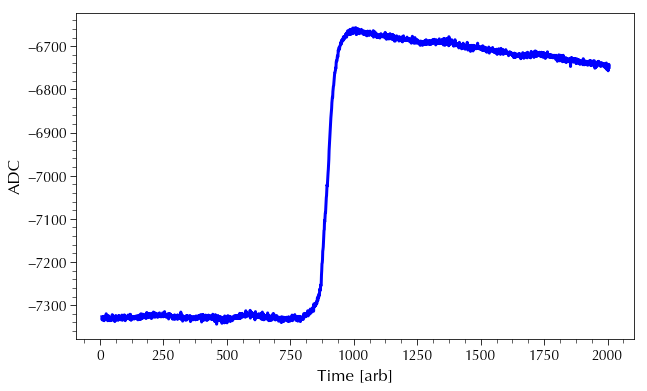

In [5]:
t1_file = glob.glob("{}/t1_run{}.h5".format(data_dir, run))[0]

with pd.HDFStore(t1_file,'r') as store:

    for key in store.keys():
        s = store.get_storer(key)
        print(key, "\n   ", s)
        
    df_tier1 = store.get("ORSIS3302DecoderForEnergy") # careful, it can be a lot to load in RAM
        
    df_garbage = store.get("ORSIS3302DecoderForEnergy_Garbage")
        
    df_metadata = store.get("ORSIS3302Model")
    
    
    print("\n TIER 1 EVENT DATA:")
    print(df_tier1.head())
    
    print("\n TIER 1 GARBAGE DATA:")
    print(df_garbage.head())
    
    print("\n TIER 1 METADATA (DIGITIZER INFO):")
    print(df_metadata.columns)


    # grab a waveform
    cols = df_tier1.columns.values
    t_start = np.where(cols == 0)[0][0]
    t_stop = len(cols)-1
    wf = df_tier1.iloc[0, t_start:t_stop].values
    ts = np.arange(0, len(wf), 1) + t_start
    
    fig = plt.figure(figsize=(10,6))
    plt.plot(ts, wf, '-b')
    plt.xlabel("Time [arb]")
    plt.ylabel("ADC")
    plt.show()

## Run ProcessTier1

We declare a `Tier1Processor` and create the **list of calculations/transforms** we want to do.  This is a good place to convert a multisampled waveform, do a database lookup to get nonlinearity parameters, and run various transforms (waveform-valued) and calculators (single-valued).

In [8]:
from pygama.processing.base import Tier1Processor
from pygama.processing.tier1 import ProcessTier1

t1_file = glob.glob("{}/t1_run{}.h5".format(data_dir, run))[0]

# declare our processor list
proc = Tier1Processor(t1_options)
proc.add("fit_baseline", {"i_end":800})
proc.add("bl_subtract")
proc.add("trap_filter")
proc.add("trap_max", {"test":False})

# NOTE: using {'test':True} displays a plot,
# won't work when multiprocessing is enabled

# proc = Tier1Processor(t1_options, default_list=True) # cop out

ProcessTier1(t1_file,
             proc,
             out_prefix="t2",
             out_dir=data_dir,
             verbose=True,
             multiprocess=True,
             settings=t1_options[run])

ERROR! unknown function: 43243


NameError: name 'sys' is not defined

## Run in interactive mode (test new processors)

Let's run ProcessTier1 again, and display a diagnostic plot from within the trapezoid calculator 

(This is in `pygama.processing.transforms::trap_filter`)

Starting pygama Tier 1 processing ...
   Input file: /Users/wisecg/project/pygama/t1_run72.h5
Processing data from digitizer: ORSIS3302DecoderForEnergy


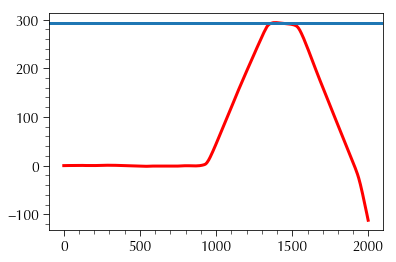

NameError: name 'exit' is not defined

In [6]:
proc = Tier1Processor(t1_options)
proc.add("fit_baseline", {"i_end":800})
proc.add("bl_subtract")
proc.add("trap_filter")
proc.add("trap_max", {"test":True}) # <---- this is different from before!

ProcessTier1(t1_file,
             proc,
             out_prefix="t2",
             out_dir=data_dir,
             verbose=True,
             multiprocess=False,  # <---- this is different from before!
             settings=t1_options[run])

## Tier 2 Output

let's make some plots!

In [7]:
from pygama.utils import get_hist

t2_file = glob.glob("{}/t2_run{}.h5".format(data_dir, run))[0]
t2_df = pd.read_hdf(t2_file)

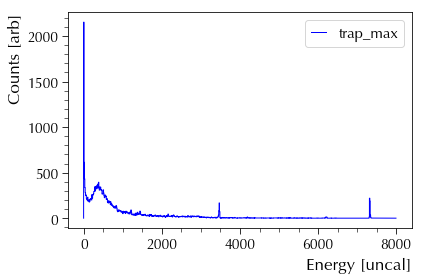

In [8]:
# set histogram limits
x_lo, x_hi, xpb = 0, 8000, 10
nb = int((x_hi-x_lo)/xpb)

# we can do this but i don't like its look
# t2_df.hist("trap_max", bins=nb, range=(x_lo, x_hi), label="trap_max")

# this is better
xH, yH = get_hist(t2_df["trap_max"], x_lo, x_hi, xpb)
plt.plot(xH, yH, c='b', lw=1, ls='steps', label="trap_max")

plt.xlabel("Energy [uncal]", ha='right', x=1)
plt.ylabel("Counts [arb]", ha='right', y=1)
plt.legend()
plt.tight_layout()